In [1]:
!pip install -q openai-whisper librosa language-tool-python textstat spacy xgboost scikit-learn pandas numpy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 35.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.6/176.6 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.5/170.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 117.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import os
import numpy as np
import pandas as pd
import librosa
import whisper
import spacy
import language_tool_python
import textstat
import xgboost as xgb
import pickle
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings

warnings.filterwarnings('ignore')
class Config:
    TRAIN_CSV = '/kaggle/input/shl-data/dataset/train.csv'
    TEST_CSV = '/kaggle/input/shl-data/dataset/test.csv'
    TRAIN_AUDIO_DIR = '/kaggle/input/shl-data/dataset/audios_train'
    TEST_AUDIO_DIR = '/kaggle/input/shl-data/dataset/audios_test'
    SEED = 42
    WORKING_DIR = '/kaggle/working'

    MODEL_SAVE_PATH = os.path.join(WORKING_DIR, 'grammar_model.pkl')
    SUBMISSION_PATH = os.path.join(WORKING_DIR, 'submission.csv')
np.random.seed(Config.SEED)

In [3]:
!apt-get update -qq > /dev/null
!apt-get install -y openjdk-17-jdk-headless -qq > /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
print("Java 17 installed and configured.")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Java 17 installed and configured.


In [4]:
print("Loading Models...")
asr_model = whisper.load_model("base")
nlp = spacy.load("en_core_web_sm")
tool = language_tool_python.LanguageTool('en-US')

print("Models Loaded Successfully.")

Loading Models...


100%|████████████████████████████████████████| 139M/139M [00:00<00:00, 302MiB/s]


Models Loaded Successfully.


In [5]:
def extract_acoustic_features(audio_path):
    """
    Analyzes audio for pauses (fluency) and speaking rate.
    """
    try:
        y, sr = librosa.load(audio_path, sr=None)
        duration = librosa.get_duration(y=y, sr=sr)

        # Split audio into non-silent chunks to find true speech duration
        non_silent_intervals = librosa.effects.split(y, top_db=20)
        non_silent_duration = sum(end - start for start, end in non_silent_intervals) / sr

        silence_duration = duration - non_silent_duration
        silence_ratio = silence_duration / duration if duration > 0 else 0

        return {
            'audio_duration': duration,
            'speech_duration': non_silent_duration,
            'silence_ratio': silence_ratio
        }
    except Exception as e:
        print(f"Error reading audio {audio_path}: {e}")
        return {'audio_duration': 0, 'speech_duration': 0, 'silence_ratio': 0}

def extract_text_features(text):
    """
    Analyzes text for grammar errors, complexity, and vocabulary.
    """
    if not text:
        return {
            'word_count': 0, 'error_count': 0, 'errors_per_word': 0,
            'ttr': 0, 'complexity_metric': 0
        }

    # 1. Grammar Mechanics
    matches = tool.check(text)
    error_count = len(matches)

    # 2. Vocabulary Stats
    doc = nlp(text)
    words = [token.text.lower() for token in doc if token.is_alpha]
    word_count = len(words)
    unique_words = set(words)

    # Type-Token Ratio (Vocabulary Richness)
    ttr = len(unique_words) / word_count if word_count > 0 else 0

    # 3. Complexity (Flesch-Kincaid Grade)
    try:
        complexity_metric = textstat.flesch_kincaid_grade(text)
    except:
        complexity_metric = 0

    return {
        'word_count': word_count,
        'error_count': error_count,
        'errors_per_word': error_count / max(1, word_count),
        'ttr': ttr,
        'complexity_metric': complexity_metric
    }

def process_sample(audio_path):
    """
    Full Pipeline: Audio -> Whisper -> Features
    """
    # 1. Acoustics
    acoustic_feats = extract_acoustic_features(audio_path)

    # 2. Transcription
    try:
        result = asr_model.transcribe(audio_path, initial_prompt="Transcribe exactly as spoken, including errors.")
        text = result['text']
    except Exception as e:
        print(f"Transcribe Error: {e}")
        text = ""

    # 3. Text Features
    text_feats = extract_text_features(text)

    # 4. Merge & Calculate WPM
    features = {**acoustic_feats, **text_feats}

    # Words Per Minute (Fluency Metric)
    if features['speech_duration'] > 0:
        features['wpm'] = features['word_count'] / (features['speech_duration'] / 60)
    else:
        features['wpm'] = 0

    return features

In [6]:
import os # Ensure os is imported if not already in scope
import kagglehub # Required to define harshsaini105_shl_data_path
harshsaini105_shl_data_path = kagglehub.dataset_download('harshsaini105/shl-data') # Defines the path

# Update Config paths based on where kagglehub downloaded the data
# The harshsaini105_shl_data_path variable holds the correct base path.
Config.TRAIN_CSV = os.path.join(harshsaini105_shl_data_path, 'dataset', 'train.csv')
Config.TRAIN_AUDIO_DIR = os.path.join(harshsaini105_shl_data_path, 'dataset', 'audios_train')
# Also update for test data to prevent future errors
Config.TEST_CSV = os.path.join(harshsaini105_shl_data_path, 'dataset', 'test.csv')
Config.TEST_AUDIO_DIR = os.path.join(harshsaini105_shl_data_path, 'dataset', 'audios_test')

df_train = pd.read_csv(Config.TRAIN_CSV)
print(f"Columns found: {df_train.columns.tolist()}") # Confirming columns
print(f"Training Samples: {len(df_train)}")

features_list = []
scores = []

print("Extracting features from Training Data...")
for index, row in tqdm(df_train.iterrows(), total=len(df_train)):
    file_path = os.path.join(Config.TRAIN_AUDIO_DIR, row['filename'])
    feats = process_sample(file_path)
    features_list.append(feats)
    scores.append(row['label'])
X = pd.DataFrame(features_list)
y = pd.Series(scores)
X.to_csv(os.path.join(Config.WORKING_DIR, 'X_train_features.csv'), index=False)
y.to_csv(os.path.join(Config.WORKING_DIR, 'y_train_labels.csv'), index=False)

print("\nFeature Extraction Complete.")
X.head()

100%|██████████| 1.10G/1.10G [00:12<00:00, 94.1MB/s]

Extracting files...


Columns found: ['filename', 'label']
Training Samples: 444
Extracting features from Training Data...


  0%|          | 0/444 [00:00<?, ?it/s]

OSError: Cannot save file into a non-existent directory: '/kaggle/working'

In [7]:
import os
working_dir = '/kaggle/working'

# Create the working directory if it doesn't exist
os.makedirs(working_dir, exist_ok=True)

X.to_csv(os.path.join(working_dir, 'X_train_features.csv'), index=False)
y.to_csv(os.path.join(working_dir, 'y_train_labels.csv'), index=False)

print(f"✅ Rescue successful! Data saved to {working_dir}")

✅ Rescue successful! Data saved to /kaggle/working


In [9]:
feature_cols = ['silence_ratio', 'word_count', 'error_count',
                'errors_per_word', 'ttr', 'complexity_metric', 'wpm']
X_final = X[feature_cols]
kf = KFold(n_splits=5, shuffle=True, random_state=Config.SEED)
rmse_scores = []
models = []

print("Training XGBoost Regressor with 5-Fold CV...")
for train_idx, val_idx in kf.split(X_final):
    X_train, X_val = X_final.iloc[train_idx], X_final.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    model = xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        objective='reg:squarederror',
        n_jobs=-1,
        random_state=Config.SEED
    )

    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    # Removed 'squared=False' and now take the square root of MSE to get RMSE
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    rmse_scores.append(rmse)
    models.append(model)
print(f"\nAverage RMSE: {np.mean(rmse_scores):.4f}")
final_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    objective='reg:squarederror'
)
final_model.fit(X_final, y)
with open(Config.MODEL_SAVE_PATH, 'wb') as f:
    pickle.dump(final_model, f)
print(f"Final Model Saved to {Config.MODEL_SAVE_PATH}")

Training XGBoost Regressor with 5-Fold CV...

Average RMSE: 1.0356
Final Model Saved to /kaggle/working/grammar_model.pkl


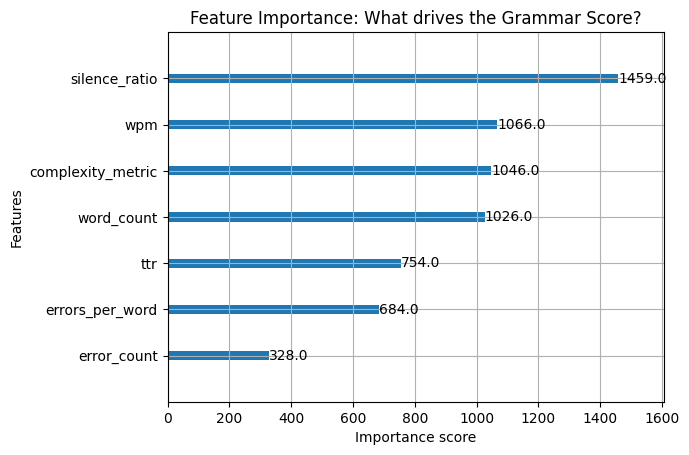

In [ ]:
import matplotlib.pyplot as plt

xgb.plot_importance(final_model)
plt.title("Feature Importance: What drives the Grammar Score?")
plt.show()

In [10]:
df_test = pd.read_csv(Config.TEST_CSV)
print(f"Testing Samples: {len(df_test)}")

test_features_list = []

print("Extracting features from Test Data...")
for index, row in tqdm(df_test.iterrows(), total=len(df_test)):
    file_path = os.path.join(Config.TEST_AUDIO_DIR, row['filename'])

    if os.path.exists(file_path):
        feats = process_sample(file_path)
    else:
        feats = {'silence_ratio': 0, 'word_count': 0, 'error_count': 0,
                 'errors_per_word': 0, 'ttr': 0, 'complexity_metric': 0, 'wpm': 0}
    test_features_list.append(feats)
X_test = pd.DataFrame(test_features_list)
X_test_final = X_test[feature_cols]
test_preds = final_model.predict(X_test_final)
test_preds = np.clip(test_preds, 0, 5)
submission = pd.DataFrame({
    'filename': df_test['filename'],
    'score': test_preds
})
submission.to_csv('../submission.csv', index=False)
print("Submission file created: ../submission.csv")
submission.head()

Testing Samples: 195
Extracting features from Test Data...


  0%|          | 0/195 [00:00<?, ?it/s]

Submission file created: ../submission.csv


,filename,score
0,audio_706.wav,4.417516
1,audio_800.wav,2.489307
2,audio_68.wav,2.492497
3,audio_1267.wav,3.597353
4,audio_683.wav,2.697116


In [11]:
import random
import pandas as pd
test_files = os.listdir(Config.TEST_AUDIO_DIR)
random_file = random.choice(test_files)
audio_path = os.path.join(Config.TEST_AUDIO_DIR, random_file)

print(f"🎤 Analyzing: {os.path.basename(audio_path)}")

features = process_sample(audio_path)
df_single = pd.DataFrame([features])
feature_cols = ['silence_ratio', 'word_count', 'error_count',
                'errors_per_word', 'ttr', 'complexity_metric', 'wpm']
X_single = df_single[feature_cols]
predicted_score = model.predict(X_single)[0]
print("\n" + "="*40)
print(f"🏆 PREDICTED SCORE: {predicted_score:.2f} / 10")
print("="*40)
print(f"\n📊 WHY DID IT GET THIS SCORE?")
print(f"• Speaking Rate:    {features['wpm']:.0f} WPM  (Ideal: 120-150)")
print(f"• Grammar Errors:   {features['error_count']} detected")
print(f"• Error Density:    {features['errors_per_word']*100:.1f}% of words")
print(f"• Silence Ratio:    {features['silence_ratio']*100:.1f}% (Pauses)")
print(f"• Vocabulary Score: {features['ttr']:.2f} (Type-Token Ratio)")
print("\n📝 TRANSCRIPTION SEEN BY MODEL:")
if 'text' not in features:
    res = asr_model.transcribe(audio_path)
    print(f"\"{res['text'].strip()}\"")

🎤 Analyzing: audio_103.wav

🏆 PREDICTED SCORE: 4.38 / 10

📊 WHY DID IT GET THIS SCORE?
• Speaking Rate:    21 WPM  (Ideal: 120-150)
• Grammar Errors:   4 detected
• Error Density:    17.4% of words
• Silence Ratio:    64.3% (Pauses)
• Vocabulary Score: 0.96 (Type-Token Ratio)

📝 TRANSCRIPTION SEEN BY MODEL:
"mock it could so Pass through the subscribes. Pass through the heck Funch fresh are damp as ice But has fish which show Left it, you are free to Lettuce of your past birthup story"
